## Data manipolation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qdatoolkit as qda

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,80444000.0,26.048,-66.325,21.12,528,801.0,798.0,1591.9,0,119,0.00000,0.0
1,80444010.0,26.054,-66.332,21.12,528,803.0,798.0,1594.6,0,119,0.00816,10.0
2,80444020.0,26.061,-66.338,21.12,528,789.0,785.0,1593.3,0,119,0.01633,20.0
3,80444030.0,26.063,-66.342,21.12,528,785.0,790.0,1580.7,0,119,0.02449,30.0
4,80444040.0,26.066,-66.345,21.12,528,785.0,790.0,1580.7,0,119,0.03265,40.0


Generate a temperature matrix

In [3]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.264, 38.053)
y_range = (-66.506, -54.848)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df,layer_ids, x_range, y_range, digits_round)

/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_6274/437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
/var/folders/zb/w1kj5qrn31j0nl8g2bsgq6h40000gn/T/ipykernel_6274/437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [95]:
list_25l.shape

(25, 117, 118)

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming list_25l is a numpy array of shape (25, 120, 118)
num_layers = list_25l.shape[0]
height = list_25l.shape[1]
width = list_25l.shape[2]
smallest_cluster_pixels = []
biggest_cluster_pixels = []

for i in range(num_layers):
    # Extract the current layer
    current_layer = list_25l[i, :, :]

    # Standardize the data before reshaping for PCA
    scaler_pca = StandardScaler()
    current_layer_scaled = scaler_pca.fit_transform(current_layer)

    # Reshape the standardized data for PCA
    X = current_layer_scaled.reshape(-1, 1)

    # Apply PCA
    pca = PCA(n_components=1)
    scores = pca.fit_transform(X)

    # Compute Hotelling’s T² statistic for each pixel
    explained_variance = pca.explained_variance_
    if explained_variance[0] > 1e-8:
        T2 = (scores ** 2) / explained_variance[0]
    else:
        T2 = np.zeros_like(scores)

    # Standardize T2 values before K-means (optional but potentially useful)
    scaler_kmeans = StandardScaler()
    T2_scaled = scaler_kmeans.fit_transform(T2.reshape(-1, 1))

    # Apply K-means clustering on the T² map
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    clusters_flat = kmeans.fit_predict(T2_scaled)
    clusters_map = clusters_flat.reshape(height, width)

    # Calculate the size of each cluster
    unique_clusters, counts = np.unique(clusters_map, return_counts=True)
    cluster_sizes = dict(zip(unique_clusters, counts))

    # Find the label of the smallest and biggest cluster
    smallest_cluster_label = min(cluster_sizes, key=cluster_sizes.get)
    biggest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

    # Extract the pixel coordinates and values for the smallest cluster
    smallest_cluster_indices = np.where(clusters_map == smallest_cluster_label)
    smallest_cluster_coords = list(zip(smallest_cluster_indices[0], smallest_cluster_indices[1]))
    smallest_cluster_values = current_layer_scaled[smallest_cluster_indices]
    smallest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": smallest_cluster_label,
        "pixel_coordinates": smallest_cluster_coords,
        "pixel_values": smallest_cluster_values
    })

    # Extract the pixel coordinates and values for the biggest cluster
    biggest_cluster_indices = np.where(clusters_map == biggest_cluster_label)
    biggest_cluster_coords = list(zip(biggest_cluster_indices[0], biggest_cluster_indices[1]))
    biggest_cluster_values = current_layer_scaled[biggest_cluster_indices]
    biggest_cluster_pixels.append({
        "layer": i + 1,
        "cluster_label": biggest_cluster_label,
        "pixel_coordinates": biggest_cluster_coords,
        "pixel_values": biggest_cluster_values
    })

In [6]:
# Iterate through each layer's smallest cluster data
data = []
for layer_data in smallest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        data.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
high_T2_cluster = pd.DataFrame(data)
high_T2_cluster.head()

,x,y,temp_std,layer_id
0,0,0,2.732935,1
1,2,0,2.486629,1
2,4,0,2.301647,1
3,6,0,3.156023,1
4,7,0,1.891568,1


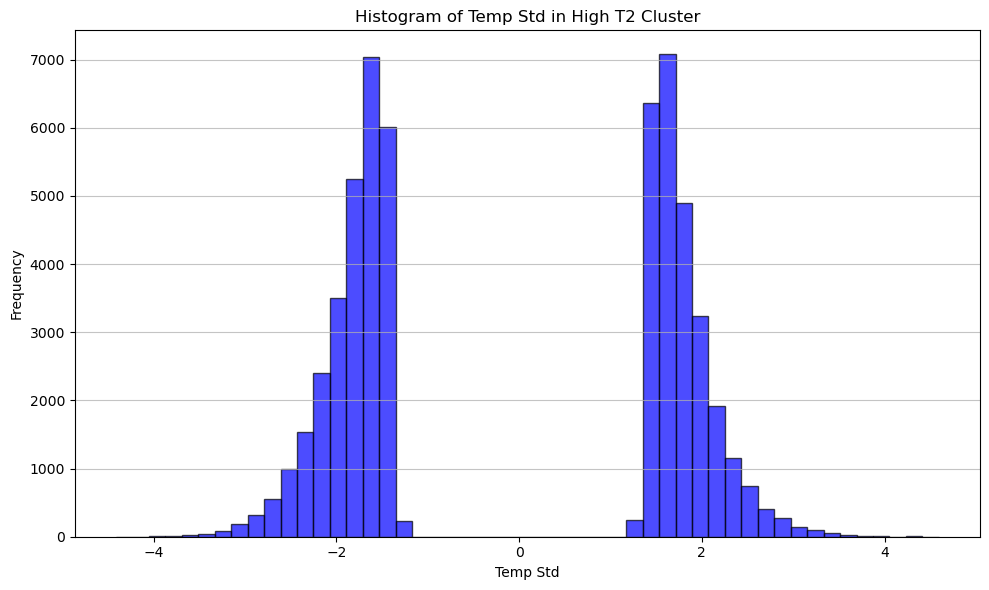

In [6]:
# Create a histogram of 'temp_std'
plt.figure(figsize=(10, 6))
plt.hist(high_T2_cluster['temp_std'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Temp Std')
plt.ylabel('Frequency')
plt.title('Histogram of Temp Std in High T2 Cluster')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

The temperature in the high T2 cluster is bimodal, signaling cold and hot spots. We separate the data at temp_std = 0.

In [7]:
# Separate into cold_spots and hot_spots based on temp_std threshold
cold_spots = high_T2_cluster[high_T2_cluster['temp_std'] < 0].copy()
hot_spots = high_T2_cluster[high_T2_cluster['temp_std'] >= 0].copy()

# Reset indices for both DataFrames
cold_spots.reset_index(drop=True, inplace=True)
hot_spots.reset_index(drop=True, inplace=True)


## Cold spots

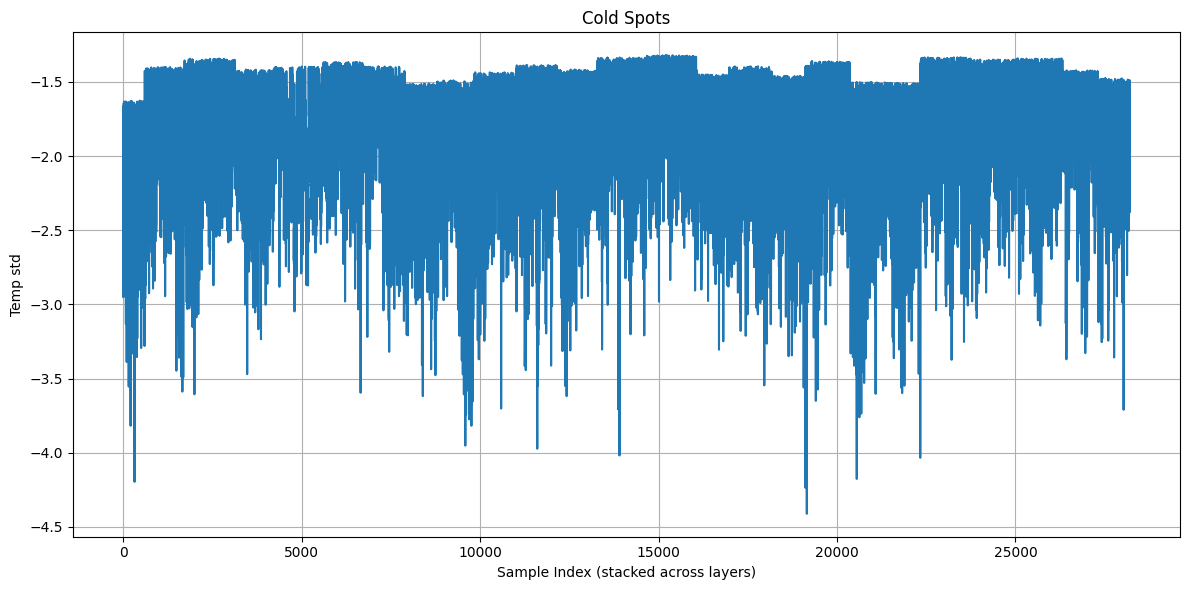

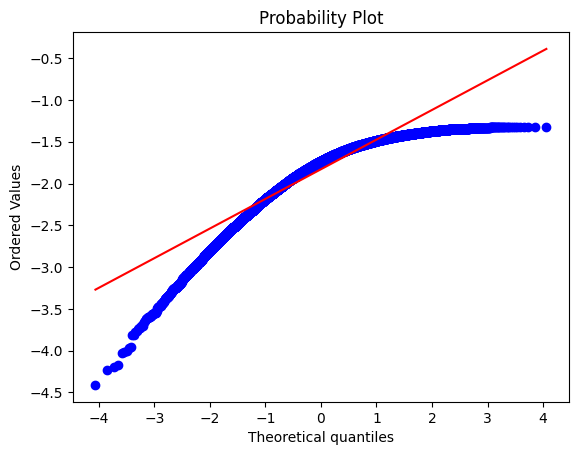

/opt/anaconda3/envs/environmentname/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.897
Shapiro-wilk test p-value = 0.000
Runs test statistic = -36.415
Runs test p-value = 0.000



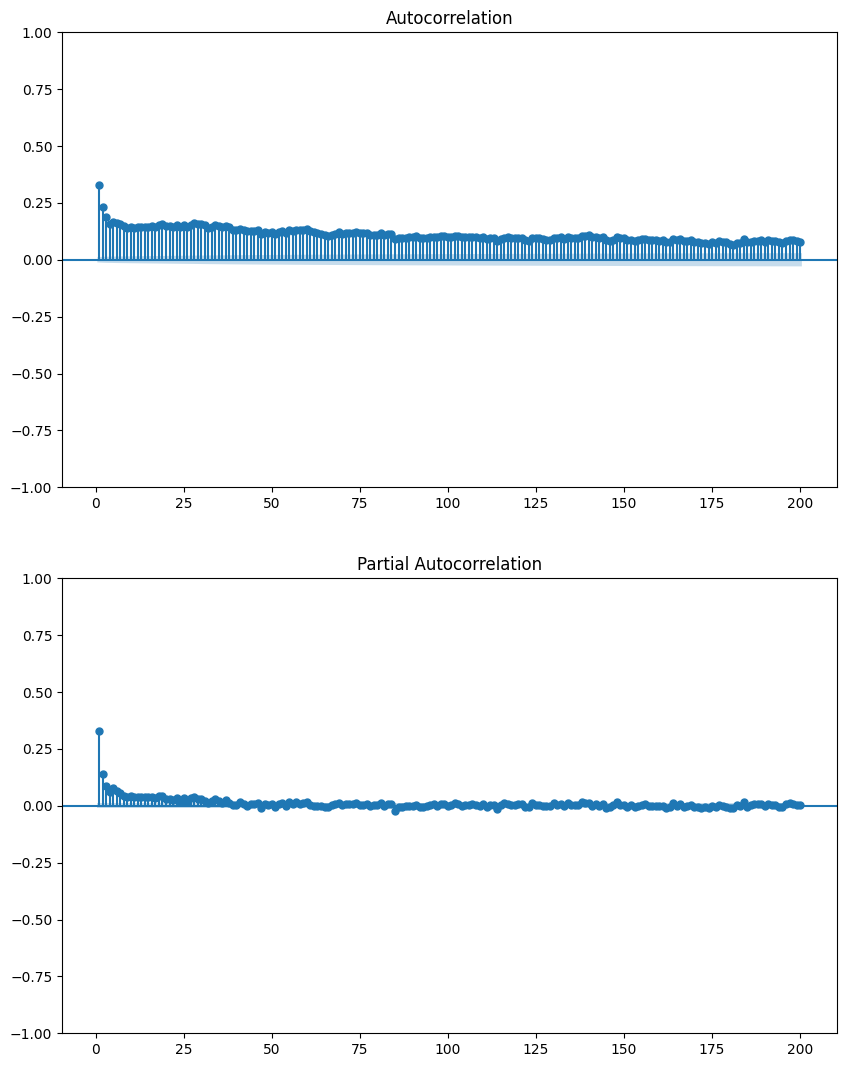

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(cold_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Cold Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(cold_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(cold_spots['temp_std']).independence()  # Controllo di indipendenza

### per ogni layer faccio media -> 1 cc con 25 punti post boxcox

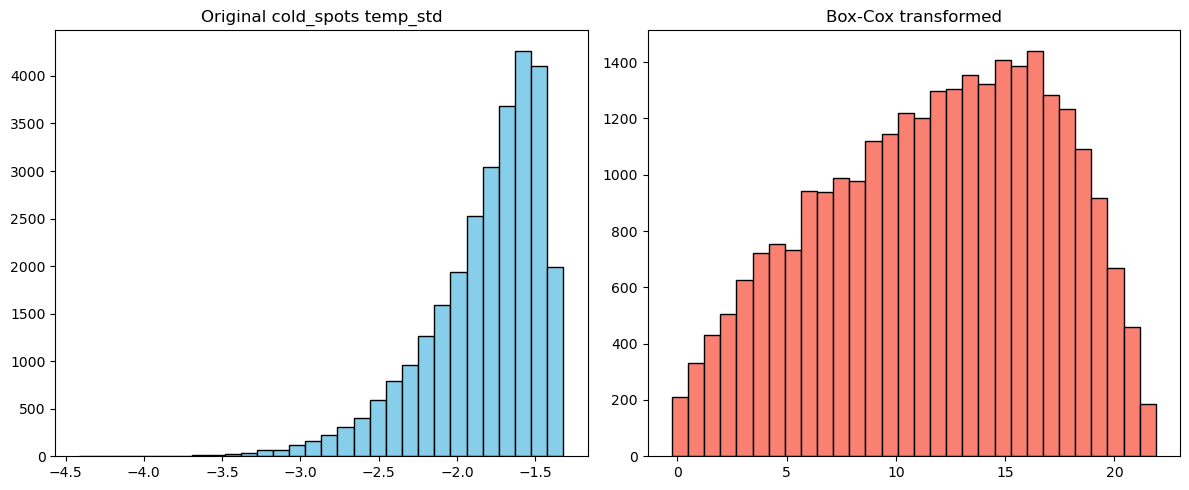

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


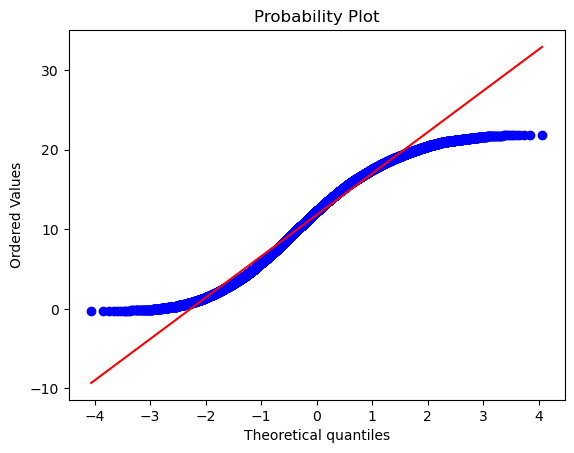

Shapiro-wilk test statistic = 0.973
Shapiro-wilk test p-value = 0.000


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
from scipy.stats import boxcox, normaltest

# Box-Cox requires values > 0, so we shift the data
min_val_cs = cold_spots['temp_std'].min()
if min_val_cs <= 0:
    shift = abs(min_val_cs) + 1e-6
else:
    shift = 0

temp_shifted_cs = cold_spots['temp_std'] + shift
temp_boxcox_cs, fitted_lambda_cs = boxcox(temp_shifted_cs)
cold_spots['temp_boxcox_cs'] = temp_boxcox_cs

# Comparison plot: before and after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(cold_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original cold_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_cs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_cs).normality()  

In [106]:
# Compute the mean of 'temp_std' for cold spots per layer
cold_spots_mean_per_layer = cold_spots.groupby('layer_id')['temp_boxcox_cs'].mean().values
print(cold_spots_mean_per_layer)

[ 8.60388461 11.52653608 12.70129307 11.97312823 10.71762098 13.46058747
 11.66250669 10.41518477  9.21588551 10.5120331  12.21472546 11.56064273
 13.90629051 14.04747966 11.40740795 10.80834692 11.39114358 12.56534223
  8.9645478  10.00527318 12.98749392 13.07468812 13.4871136  12.11893537
 11.33634772]


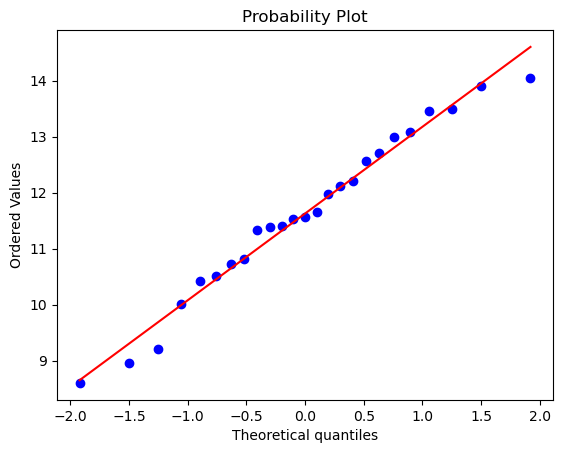

Shapiro-wilk test statistic = 0.972
Shapiro-wilk test p-value = 0.687
Runs test statistic = -0.196
Runs test p-value = 0.844



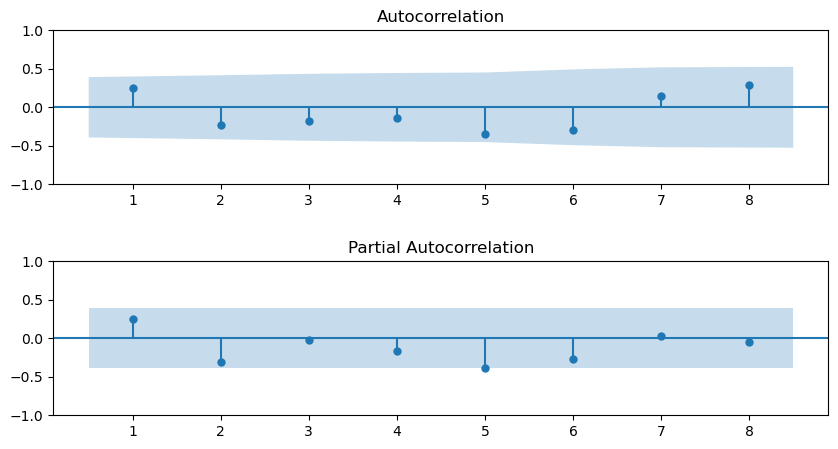

In [107]:
_=qda.Assumptions(cold_spots_mean_per_layer).normality()  # Controllo di normalità
_=qda.Assumptions(cold_spots_mean_per_layer).independence()  # Controllo di indipendenza

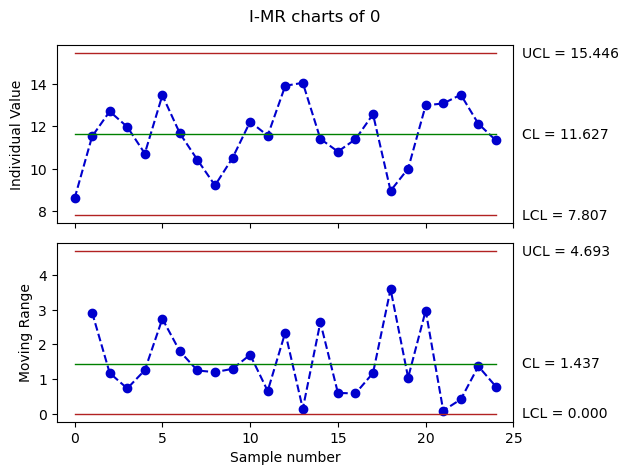

In [108]:
# DataFrame for the residuals
df_SCC_cts = pd.DataFrame(cold_spots_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_cts = qda.ControlCharts.IMR(df_SCC_cts, '0')

### 1 punto per layer - stesso modello con 9 aree

In [213]:
# Suddividi x e y in 3 intervalli ciascuno (3x3=9 aree) con lo stesso numero di punti per area
x_area_cs, x_bins_cs = pd.qcut(cold_spots['x'], q=3, labels=False, retbins=True, duplicates='drop')
y_area_cs, y_bins_cs = pd.qcut(cold_spots['y'], q=3, labels=False, retbins=True, duplicates='drop')

# Calcola area_id (1-9) secondo la posizione nella griglia 3x3
cold_spots['area_id'] = (y_area_cs * 3 + x_area_cs + 1).astype(int)

cold_spots.head()

,x,y,temp_std,layer_id,temp_boxcox_cs,area_id
0,56,1,-1.737914,1,12.207795,2
1,62,1,-1.816186,1,10.822826,2
2,68,2,-2.182259,1,5.807984,2
3,48,3,-2.951796,1,0.878297,2
4,53,4,-1.808503,1,10.953417,2


In [214]:
# Conta il numero di punti in ciascuna area_id
area_counts = cold_spots['area_id'].value_counts().sort_index()
print(area_counts)

1    3038
2    2738
3    3665
4    3313
5    3098
6    3233
7    3200
8    3473
9    2443
Name: area_id, dtype: int64


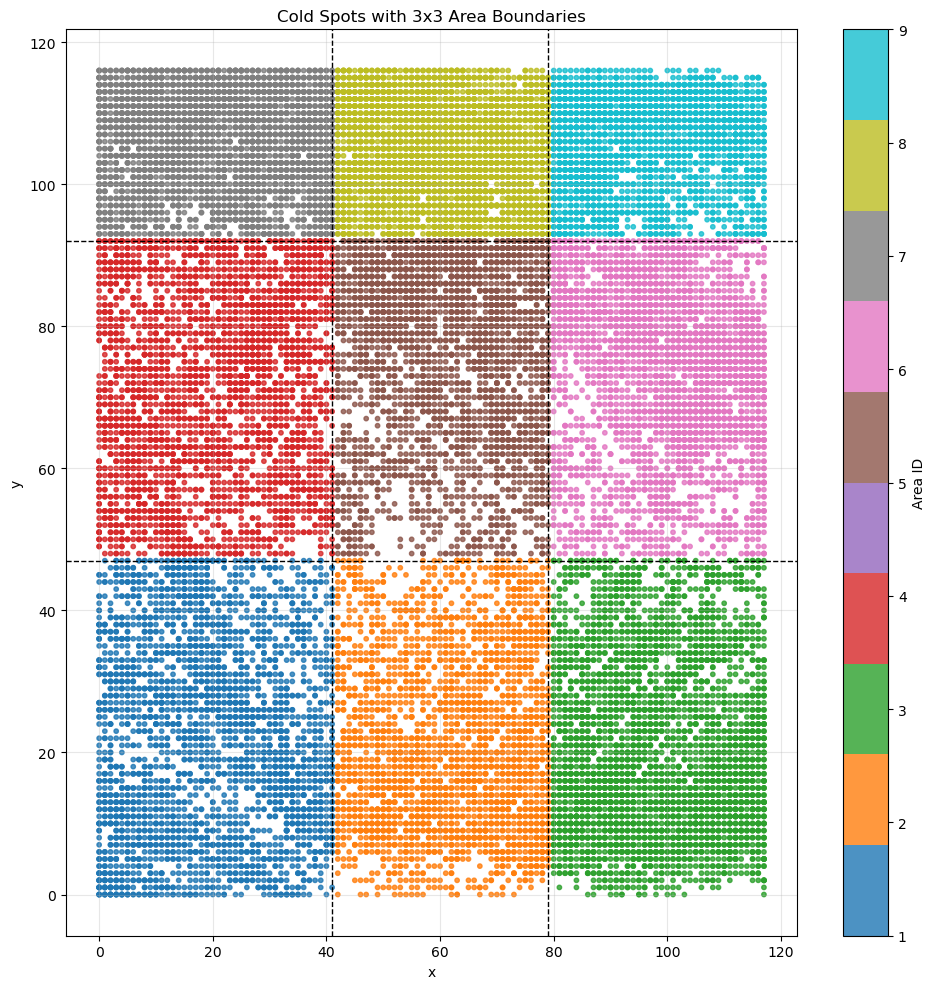

In [215]:
# Plot cold_spots with 3x3 area boundaries

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    cold_spots['x'], cold_spots['y'],
    c=cold_spots['area_id'], cmap='tab10', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cold Spots with 3x3 Area Boundaries')
plt.colorbar(scatter, ticks=range(1, 10), label='Area ID')

# Draw grid lines for area boundaries
for xb in x_bins_cs[1:-1]:
    plt.axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_cs[1:-1]:
    plt.axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [216]:
# Calcola la media della temperatura (temp_std) per ogni area_id e layer_id nei cold_spots
area_layer_mean_cs = cold_spots.groupby(['area_id', 'layer_id'])['temp_boxcox_cs'].mean().unstack()
print("Cold spots - Media temp_std per area e layer:")
print(area_layer_mean_cs)



Cold spots - Media temp_std per area e layer:
layer_id         1          2          3          4          5          6   \
area_id                                                                      
1          8.092882  10.841231  15.462841  12.358669  14.522879  13.436227   
2          9.123538  13.113851  11.539933  12.888090        NaN  15.043769   
3          8.654148  12.786890  11.376215  14.576472  18.674550        NaN   
4          8.294104  13.588847  15.389915  10.952750  14.324905  14.750521   
5          8.361358  12.388860  13.380135  11.762444  16.512754  12.727010   
6          8.578388  12.873658  16.691515  12.514293  14.297226  15.058522   
7          7.990971  14.653288  14.162417  12.164300   9.623736  14.416378   
8         10.193081  11.539736  15.207182  12.091261   9.719225  12.245081   
9          9.499922   8.974748        NaN  12.088365  10.677104  13.324661   

layer_id         7          8          9          10  ...         16  \
area_id                

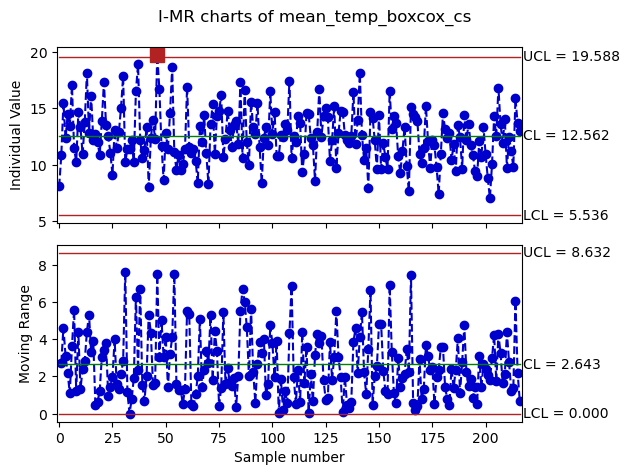

In [219]:
# Unisci tutte le medie area-layer in un unico array per cold_spots (Box-Cox trasformate)
all_area_layer_means_cs = area_layer_mean_cs.values.flatten()
# Rimuovi i NaN (alcune combinazioni area-layer potrebbero non avere dati)
all_area_layer_means_cs = all_area_layer_means_cs[~np.isnan(all_area_layer_means_cs)]

# DataFrame per il control chart
df_all_area_layer_means_cs = pd.DataFrame(all_area_layer_means_cs, columns=['mean_temp_boxcox_cs'])

# Control chart I-MR su tutti i valori Box-Cox trasformati
_ = qda.ControlCharts.IMR(df_all_area_layer_means_cs, 'mean_temp_boxcox_cs')

In [1]:
# Identify the index of the point out of control in the I-MR chart for cold spots (all_area_layer_means_cs)
# The control limits are stored in df_all_area_layer_means_cs after running qda.ControlCharts.IMR

# Get the control limits from the I-MR chart object
ucl = df_all_area_layer_means_cs['mean_temp_boxcox_cs'].mean() + 3 * df_all_area_layer_means_cs['mean_temp_boxcox_cs'].std()
lcl = df_all_area_layer_means_cs['mean_temp_boxcox_cs'].mean() - 3 * df_all_area_layer_means_cs['mean_temp_boxcox_cs'].std()

# Find indices of points out of control
out_of_control_indices = df_all_area_layer_means_cs[
    (df_all_area_layer_means_cs['mean_temp_boxcox_cs'] > ucl) | 
    (df_all_area_layer_means_cs['mean_temp_boxcox_cs'] < lcl)
].index.tolist()

print("Indices of points out of control:", out_of_control_indices)

# Map these indices back to area_id and layer_id
area_layer_pairs = list(area_layer_mean_cs.stack().index)
out_of_control_info = []
for idx in out_of_control_indices:
    if idx < len(area_layer_pairs):
        area_id, layer_id = area_layer_pairs[idx]
        out_of_control_info.append({'index': idx, 'area_id': area_id, 'layer_id': layer_id})

print("Out of control points (index, area_id, layer_id):")
for info in out_of_control_info:
    print(info)

NameError: name 'df_all_area_layer_means_cs' is not defined

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


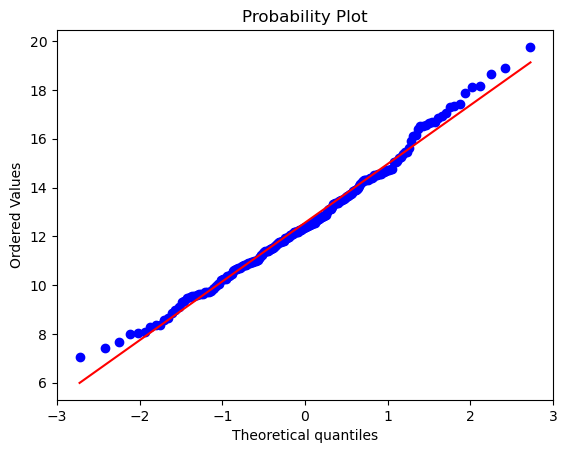

Shapiro-wilk test statistic = 0.989
Shapiro-wilk test p-value = 0.113
Runs test statistic = -0.936
Runs test p-value = 0.349



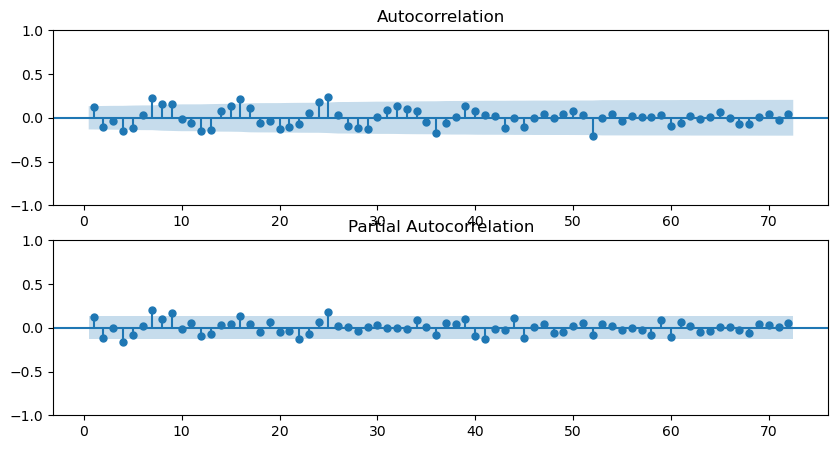

In [221]:
# Unisci tutte le medie area-layer in un unico array per cold_spots (Box-Cox trasformate)
all_area_layer_means_cs = area_layer_mean_cs.values.flatten()
# Rimuovi i NaN (alcune combinazioni area-layer potrebbero non avere dati)
all_area_layer_means_cs = all_area_layer_means_cs[~np.isnan(all_area_layer_means_cs)]

_ = qda.Assumptions(all_area_layer_means_cs).normality()
_ = qda.Assumptions(all_area_layer_means_cs).independence()


## Hot spots

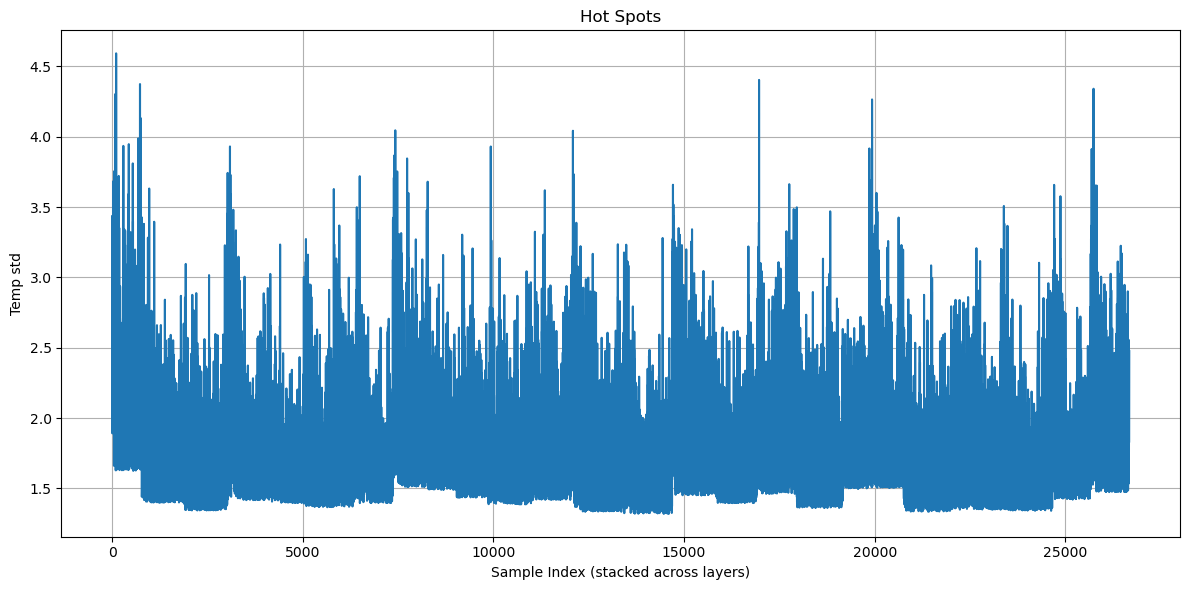

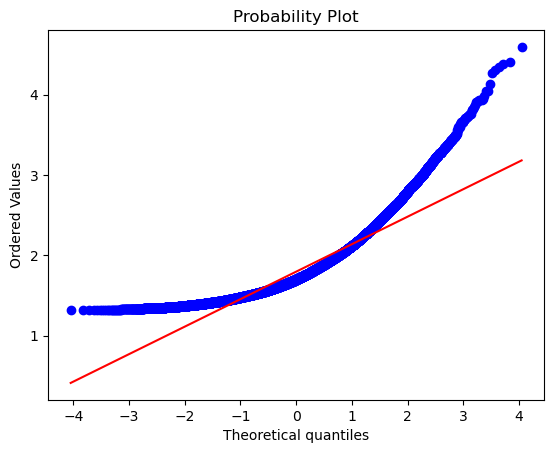

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.870
Shapiro-wilk test p-value = 0.000
Runs test statistic = -28.347
Runs test p-value = 0.000



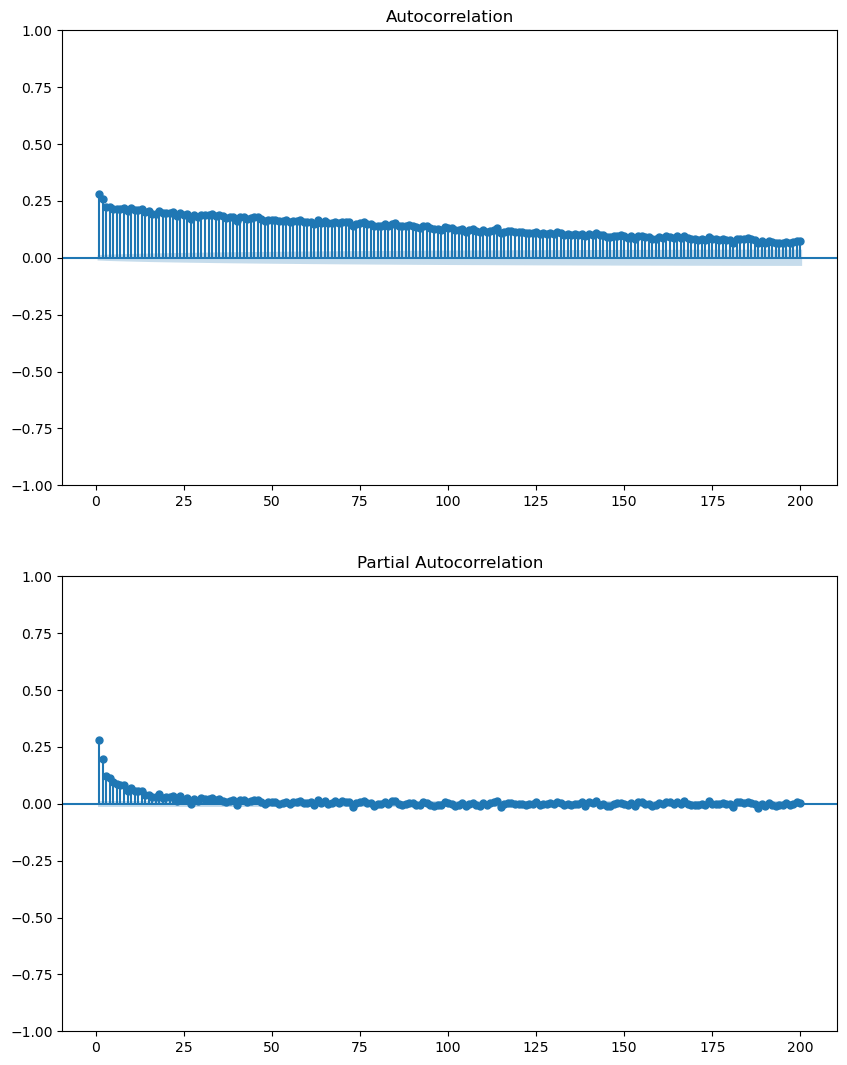

In [100]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(hot_spots['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Hot Spots')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(hot_spots['temp_std']).normality()  # Controllo di normalità
_ = qda.Assumptions(hot_spots['temp_std']).independence()  # Controllo di indipendenza

In [91]:
# Compute the mean of 'temp_std' for cold spots per layer
hot_spots_mean_per_layer = hot_spots.groupby('layer_id')['temp_std'].mean().values
print(hot_spots_mean_per_layer)

[2.18390274 1.74245556 1.66849844 1.86914496 1.67741824 1.7983694
 1.73890446 2.0072207  1.77221782 1.76086057 1.73928301 1.81428875
 1.74426466 1.70757501 1.92125379 1.70065095 1.92732534 1.69583488
 1.79785317 1.97103756 1.65230193 1.73497571 1.73445886 1.83876897
 1.97531731]


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


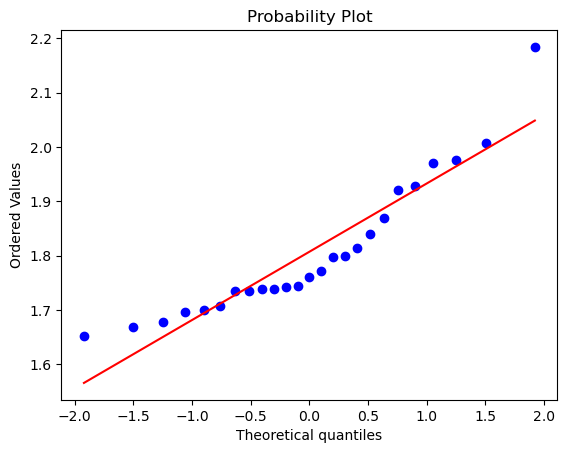

Shapiro-wilk test statistic = 0.883
Shapiro-wilk test p-value = 0.008
Runs test statistic = 1.104
Runs test p-value = 0.270



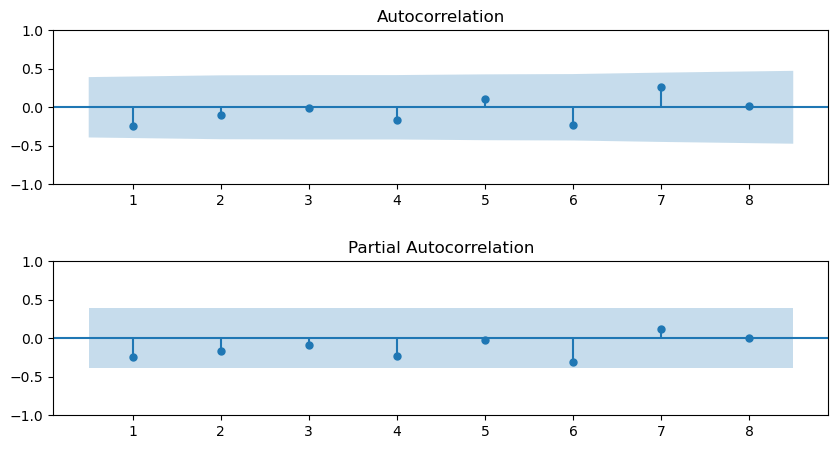

In [92]:
_=qda.Assumptions(hot_spots_mean_per_layer).normality()  # Controllo di normalità
_=qda.Assumptions(hot_spots_mean_per_layer).independence()  # Controllo di indipendenza

### 1 punto per layer -> 1 cc con 25 punti post boxcox

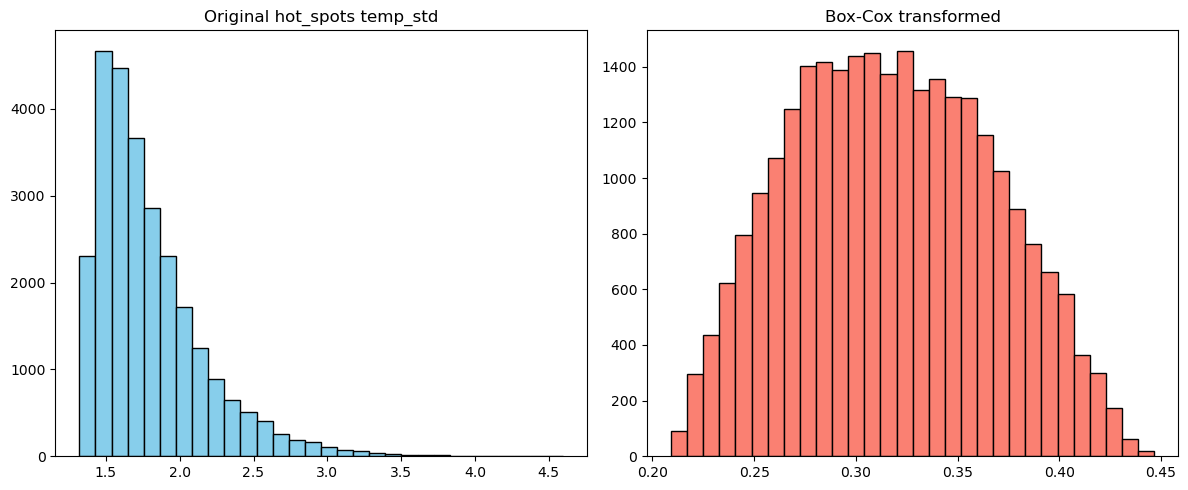

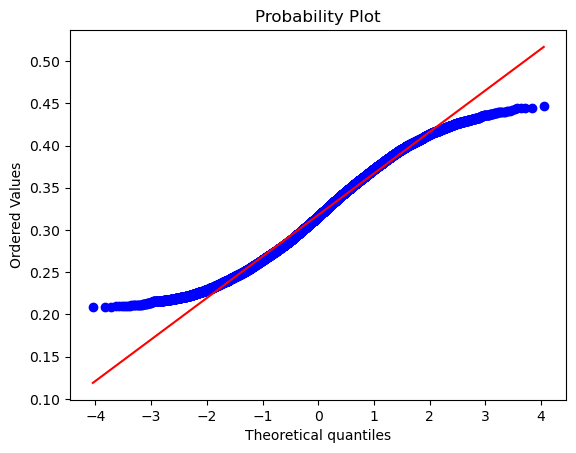

Shapiro-wilk test statistic = 0.986
Shapiro-wilk test p-value = 0.000


In [9]:
# Box-Cox requires values > 0, so we shift the data
min_val_hs = hot_spots['temp_std'].min()
if min_val_hs <= 0:
    shift = abs(min_val_hs) + 1e-6
else:
    shift = 0

temp_shifted_hs = hot_spots['temp_std'] + shift
temp_boxcox_hs, fitted_lambda_hs = boxcox(temp_shifted_hs)
hot_spots['temp_boxcox_hs'] = temp_boxcox_hs

# Comparison plot: before and after
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(hot_spots['temp_std'], bins=30, color='skyblue', edgecolor='k')
plt.title('Original hot_spots temp_std')
plt.subplot(1,2,2)
plt.hist(temp_boxcox_hs, bins=30, color='salmon', edgecolor='k')
plt.title('Box-Cox transformed')
plt.tight_layout()
plt.show()

_=qda.Assumptions(temp_boxcox_hs).normality() 

In [226]:
# Compute the mean of 'temp_std' for cold spots per layer
hot_spots_mean_per_layer = hot_spots.groupby('layer_id')['temp_boxcox_hs'].mean().values
print(hot_spots_mean_per_layer)

[0.36527961 0.31221082 0.29781079 0.32842886 0.3025091  0.31757941
 0.31062962 0.34568481 0.32143032 0.31634593 0.31057459 0.32209391
 0.3067986  0.30171456 0.33567104 0.30657663 0.33645347 0.30286827
 0.32485971 0.34267577 0.29447269 0.30870061 0.30733899 0.32397005
 0.34318872]


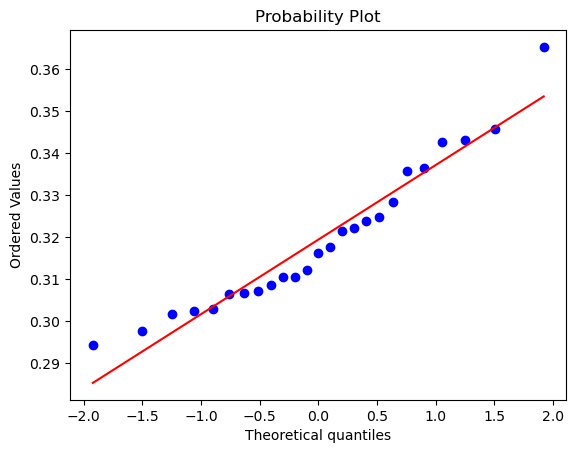

Shapiro-wilk test statistic = 0.938
Shapiro-wilk test p-value = 0.131
Runs test statistic = 0.697
Runs test p-value = 0.486



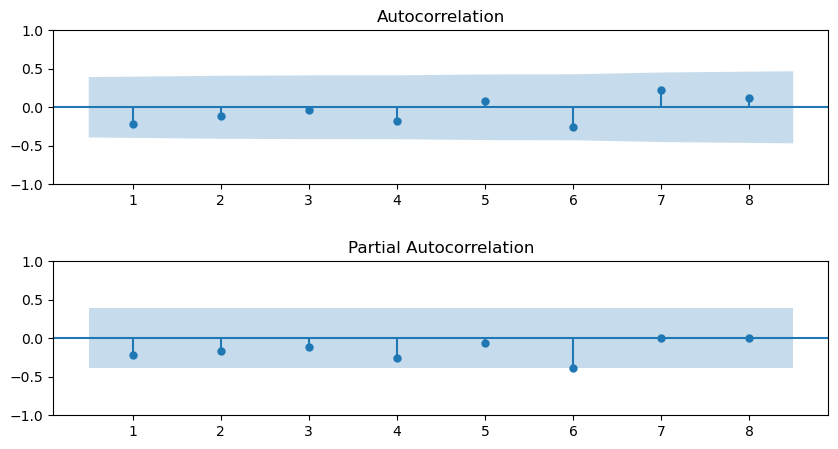

In [227]:
_=qda.Assumptions(hot_spots_mean_per_layer).normality()  # Controllo di normalità
_=qda.Assumptions(hot_spots_mean_per_layer).independence()  # Controllo di indipendenza

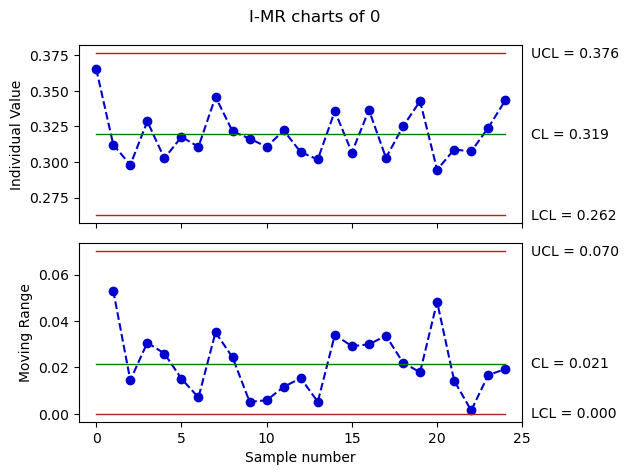

In [228]:
# DataFrame for the residuals
df_SCC_ths = pd.DataFrame(hot_spots_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_ths = qda.ControlCharts.IMR(df_SCC_ths, '0')

### 9 aree

In [10]:
# Suddividi x e y in 3 intervalli ciascuno (3x3=9 aree) con lo stesso numero di punti per area
x_area_hs, x_bins_hs = pd.qcut(hot_spots['x'], q=3, labels=False, retbins=True, duplicates='drop')
y_area_hs, y_bins_hs = pd.qcut(hot_spots['y'], q=3, labels=False, retbins=True, duplicates='drop')

# Calcola area_id (1-9) secondo la posizione nella griglia 3x3
hot_spots['area_id'] = (y_area_hs * 3 + x_area_hs + 1).astype(int)


In [11]:
# Conta il numero di punti in ciascuna area_id
area_counts = hot_spots['area_id'].value_counts().sort_index()
print(area_counts)

1    2622
2    3077
3    3233
4    3021
5    3249
6    2626
7    3477
8    2429
9    2941
Name: area_id, dtype: int64


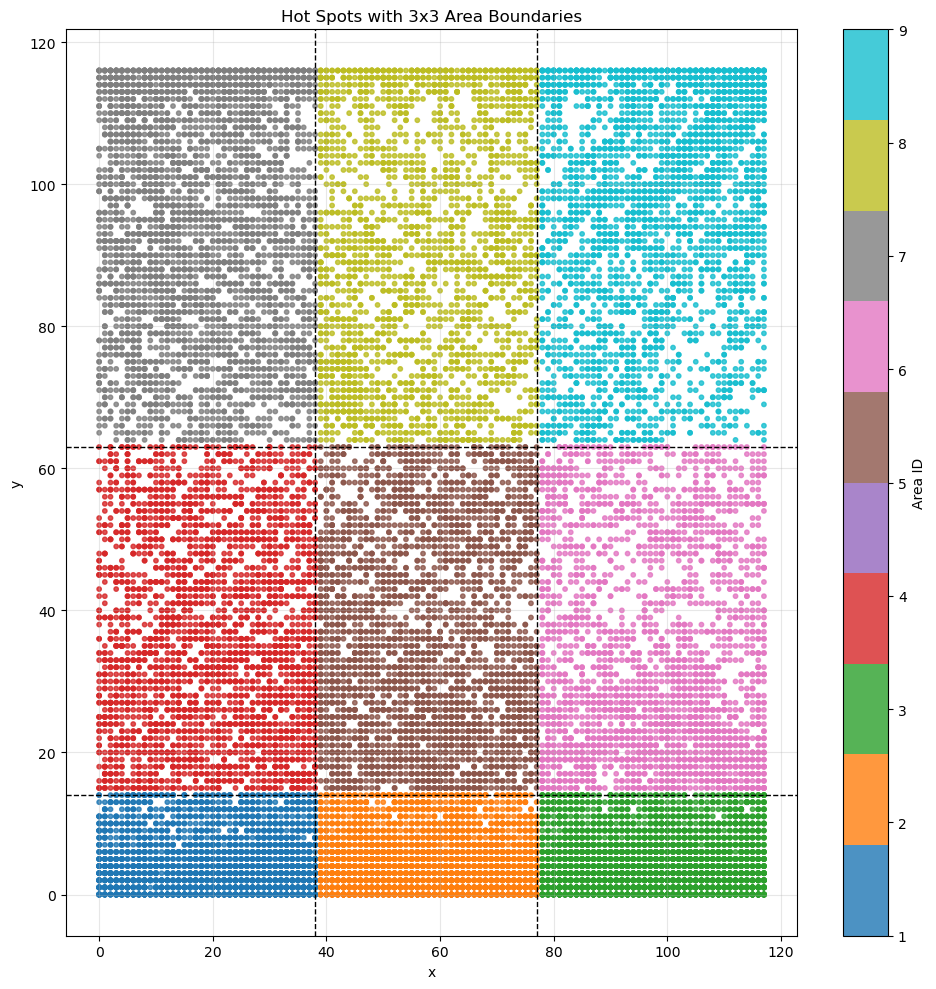

In [247]:
# Plot hot_spots con i confini delle 9 aree (3x3)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    hot_spots['x'], hot_spots['y'],
    c=hot_spots['area_id'], cmap='tab10', s=10, alpha=0.8
)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hot Spots with 3x3 Area Boundaries')
plt.colorbar(scatter, ticks=range(1, 10), label='Area ID')

# Draw grid lines for area boundaries (hot spots)
for xb in x_bins_hs[1:-1]:
    plt.axvline(x=xb, color='k', linestyle='--', linewidth=1)
for yb in y_bins_hs[1:-1]:
    plt.axhline(y=yb, color='k', linestyle='--', linewidth=1)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Calcola la media della temperatura (temp_std) per ogni area_id e layer_id nei cold_spots
area_layer_mean_hs = hot_spots.groupby(['area_id', 'layer_id'])['temp_boxcox_hs'].mean().unstack()
print("Hot spots - Media temp_boxcox per area e layer:")
print(area_layer_mean_hs)


Hot spots - Media temp_boxcox per area e layer:
layer_id        1         2         3         4         5         6   \
area_id                                                                
1         0.371629       NaN  0.295383  0.332083  0.312341  0.338676   
2         0.371137  0.339453  0.316991  0.336341  0.290716  0.325756   
3         0.372400  0.326120  0.292284  0.342629  0.325972  0.321483   
4         0.350973  0.302387  0.299766  0.319159  0.290187  0.302162   
5         0.370280  0.312648  0.291979  0.307242  0.275917  0.312614   
6         0.348603  0.317941  0.281947  0.294207  0.300887  0.289939   
7         0.370273  0.305676  0.285920  0.329607  0.302309  0.322239   
8         0.359953  0.310241  0.296575  0.320599  0.261866  0.322041   
9         0.362666  0.315978  0.299334  0.314247  0.288714       NaN   

layer_id        7         8         9         10  ...        16        17  \
area_id                                           ...                       
1    

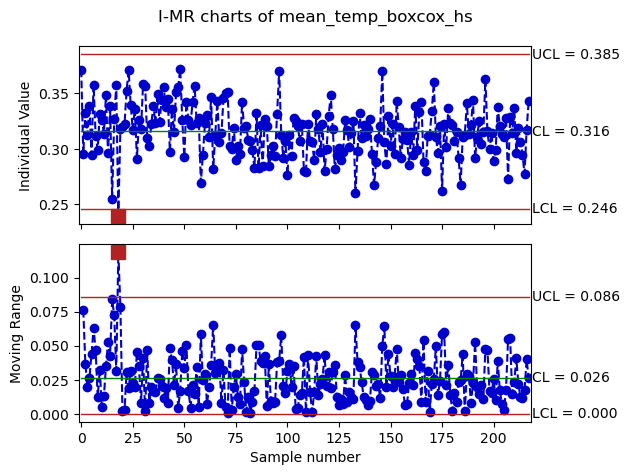

In [13]:
# Unisci tutte le medie area-layer in un unico array per cold_spots (Box-Cox trasformate)
all_area_layer_means_hs = area_layer_mean_hs.values.flatten()
# Rimuovi i NaN (alcune combinazioni area-layer potrebbero non avere dati)
all_area_layer_means_hs = all_area_layer_means_hs[~np.isnan(all_area_layer_means_hs)]

# DataFrame per il control chart
df_all_area_layer_means_hs = pd.DataFrame(all_area_layer_means_hs, columns=['mean_temp_boxcox_hs'])

# Control chart I-MR su tutti i valori Box-Cox trasformati
_ = qda.ControlCharts.IMR(df_all_area_layer_means_hs, 'mean_temp_boxcox_hs')

In [14]:
# Identify the index of the point out of control in the I-MR chart for cold spots (all_area_layer_means_cs)
# The control limits are stored in df_all_area_layer_means_cs after running qda.ControlCharts.IMR

# Get the control limits from the I-MR chart object
ucl = df_all_area_layer_means_hs['mean_temp_boxcox_hs'].mean() + 3 * df_all_area_layer_means_hs['mean_temp_boxcox_hs'].std()
lcl = df_all_area_layer_means_hs['mean_temp_boxcox_hs'].mean() - 3 * df_all_area_layer_means_hs['mean_temp_boxcox_hs'].std()

# Find indices of points out of control
out_of_control_indices = df_all_area_layer_means_hs[
    (df_all_area_layer_means_hs['mean_temp_boxcox_hs'] > ucl) | 
    (df_all_area_layer_means_hs['mean_temp_boxcox_hs'] < lcl)
].index.tolist()

print("Indices of points out of control:", out_of_control_indices)

# Map these indices back to area_id and layer_id
area_layer_pairs = list(area_layer_mean_hs.stack().index)
out_of_control_info = []
for idx in out_of_control_indices:
    if idx < len(area_layer_pairs):
        area_id, layer_id = area_layer_pairs[idx]
        out_of_control_info.append({'index': idx, 'area_id': area_id, 'layer_id': layer_id})

print("Out of control points (index, area_id, layer_id):")
for info in out_of_control_info:
    print(info)

Indices of points out of control: [18]
Out of control points (index, area_id, layer_id):
{'index': 18, 'area_id': 1, 'layer_id': 21}


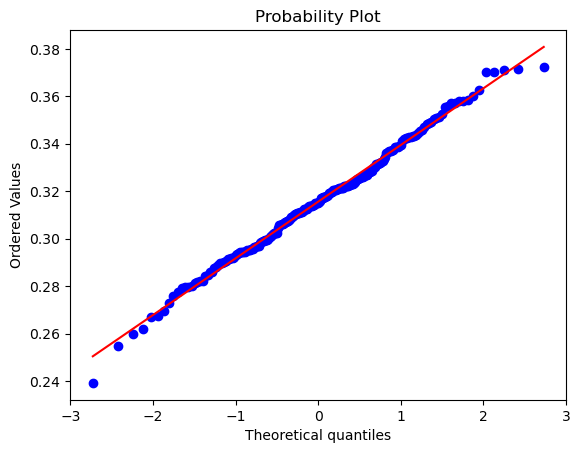

Shapiro-wilk test statistic = 0.995
Shapiro-wilk test p-value = 0.623
Runs test statistic = -0.135
Runs test p-value = 0.893



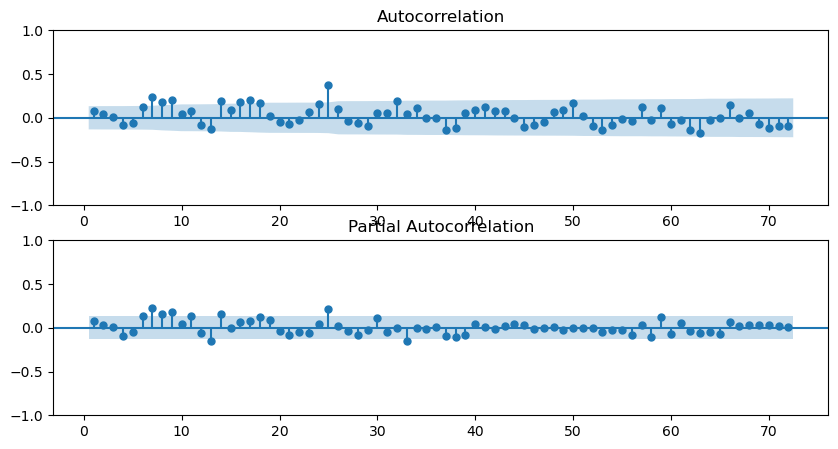

In [266]:
# Unisci tutte le medie area-layer in un unico array per cold_spots (Box-Cox trasformate)
all_area_layer_means_hs = area_layer_mean_hs.values.flatten()
# Rimuovi i NaN (alcune combinazioni area-layer potrebbero non avere dati)
all_area_layer_means_hs = all_area_layer_means_hs[~np.isnan(all_area_layer_means_hs)]

_ = qda.Assumptions(all_area_layer_means_hs).normality()
_ = qda.Assumptions(all_area_layer_means_hs).independence()

## Regular Points

In [15]:
# Iterate through each layer's biggest cluster data
regular_data_list = []
for layer_data in biggest_cluster_pixels:
    layer_id = layer_data['layer']
    pixel_coordinates = layer_data['pixel_coordinates']
    pixel_values = layer_data['pixel_values']
    
    # Add each pixel's data to the list
    for (y, x), temp_std in zip(pixel_coordinates, pixel_values):
        regular_data_list.append({'x': x, 'y': y, 'temp_std': temp_std, 'layer_id': layer_id})

# Create a DataFrame from the list
regular_data = pd.DataFrame(regular_data_list)
regular_data.head()

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,3,0,0.606690,1
2,5,0,0.475641,1
3,9,0,1.329965,1
4,11,0,0.945900,1


In [20]:
# Batch the regular_data DataFrame by keeping 1 row every 5
generate_temperature_matrices_v1_size = 5
gapped_data = regular_data.iloc[::5].reset_index(drop=True)
gapped_data.head() 

,x,y,temp_std,layer_id
0,1,0,1.368609,1
1,13,0,0.973318,1
2,25,0,-0.714688,1
3,34,0,1.174879,1
4,41,0,0.929085,1


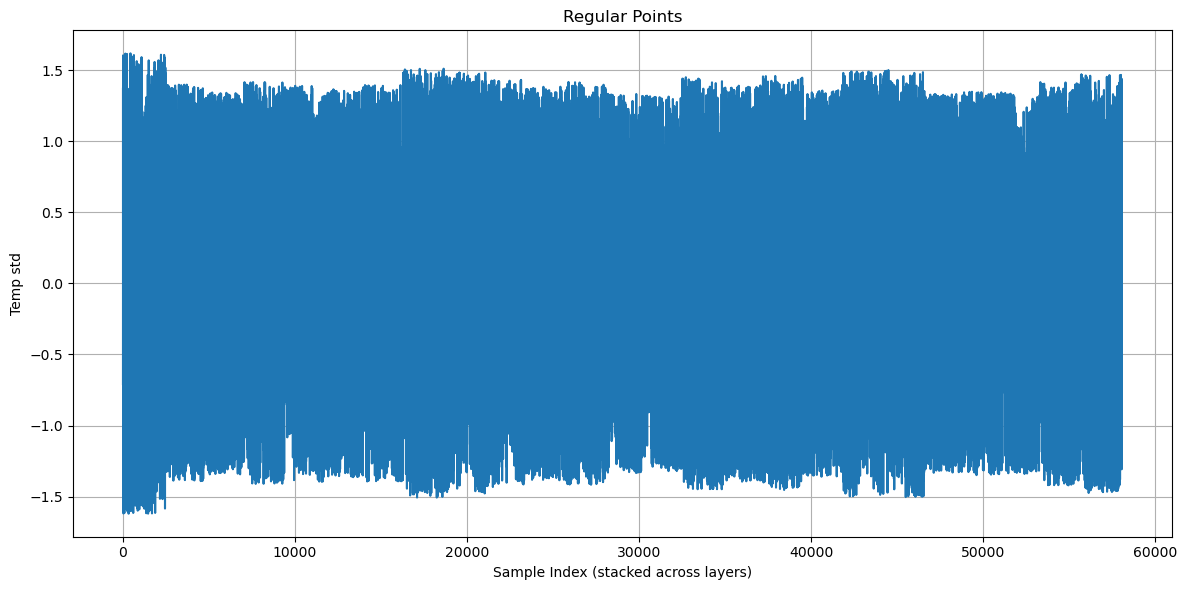

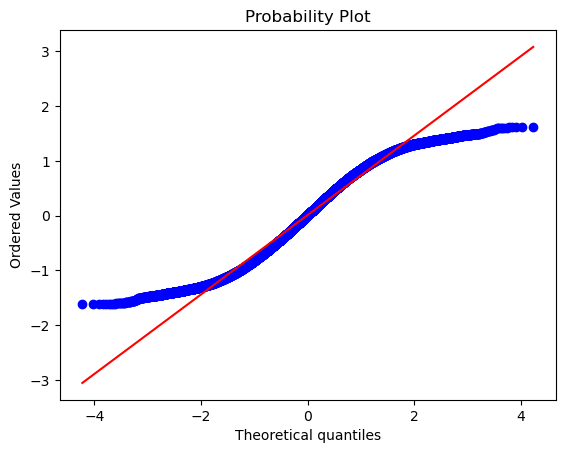

/opt/anaconda3/envs/qda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.976
Shapiro-wilk test p-value = 0.000
Runs test statistic = -37.681
Runs test p-value = 0.000



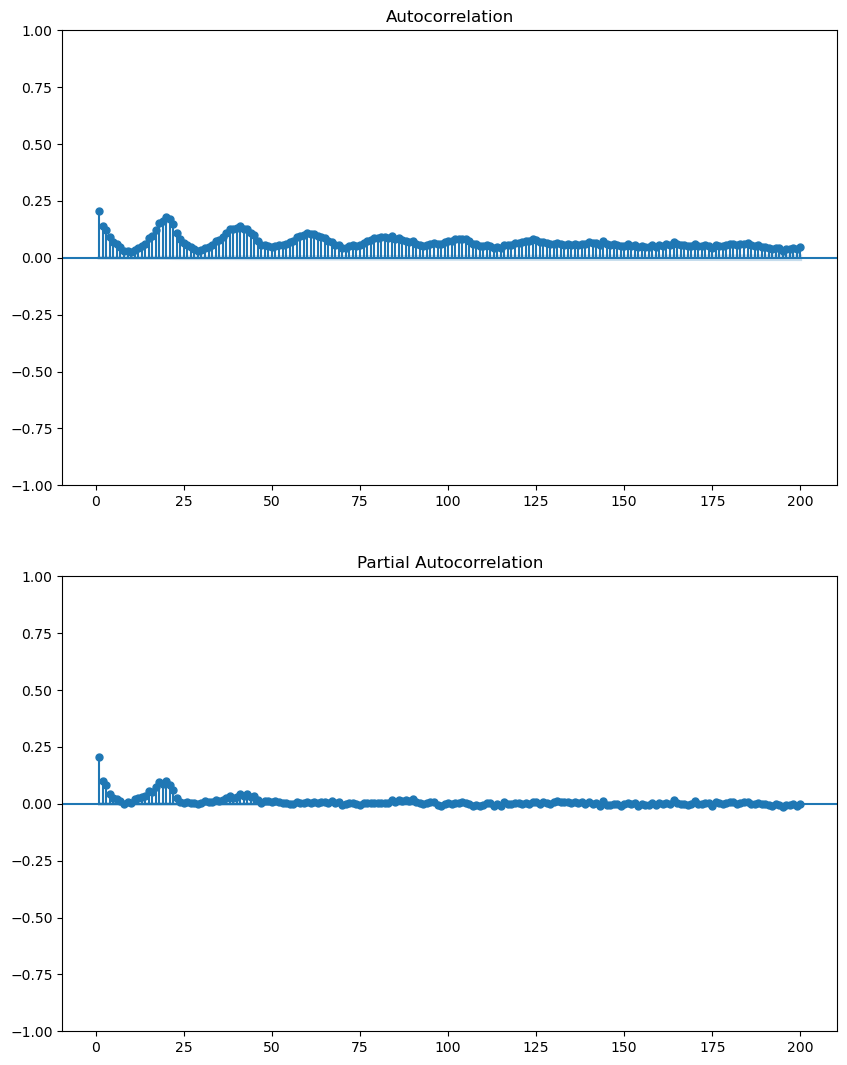

In [10]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(gapped_data['temp_std'], label='Temp std')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('Temp std')
plt.title('Regular Points')
plt.grid(True)
plt.tight_layout()
plt.show()

_ = qda.Assumptions(gapped_data['temp_std']).normality()
_ = qda.Assumptions(gapped_data['temp_std']).independence()  

In [25]:
regular_point_mean_per_layer = gapped_data.groupby('layer_id')['temp_std'].mean().values
print(regular_point_mean_per_layer)

[-0.04330063  0.02659924  0.06624767 -0.00830716  0.10003022 -0.02831249
  0.01496439 -0.01244845  0.0856816   0.07488651  0.0080116  -0.00900362
  0.00439388  0.00513254 -0.03932876  0.0504077  -0.03348537  0.02598521
  0.05437439 -0.00359549  0.03942833  0.00549761 -0.0204488   0.00023417
 -0.04332003]


/opt/anaconda3/envs/qda/lib/python3.9/site-packages/qdatoolkit/models.py:731: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


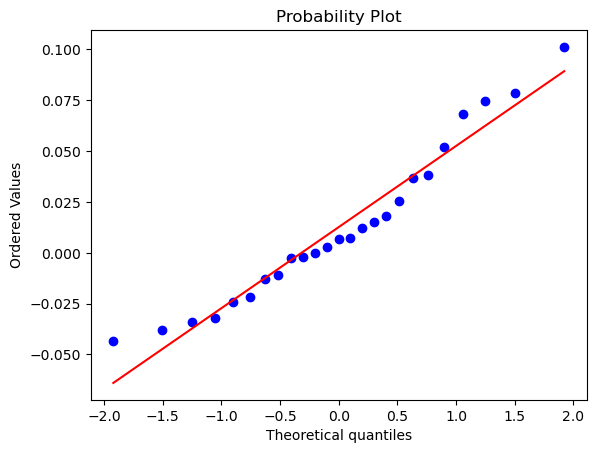

Shapiro-wilk test statistic = 0.948
Shapiro-wilk test p-value = 0.230
Runs test statistic = 1.706
Runs test p-value = 0.088



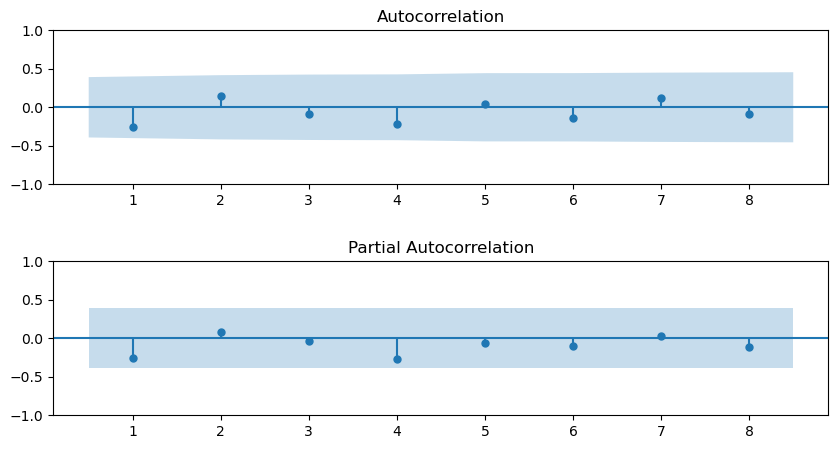

In [24]:
_=qda.Assumptions(regular_point_mean_per_layer).normality()  # Controllo di normalità
_=qda.Assumptions(regular_point_mean_per_layer).independence()  # Controllo di indipendenza

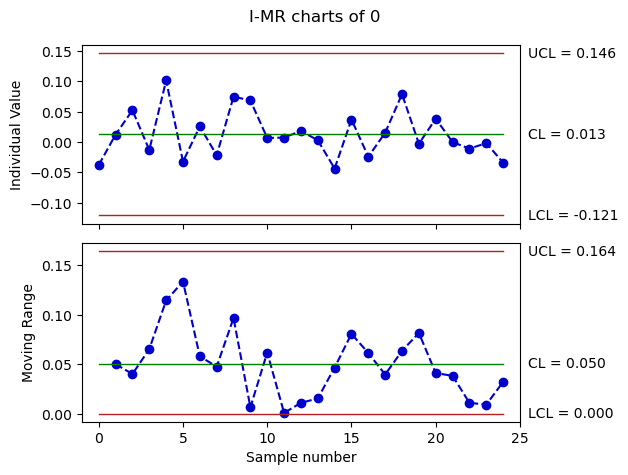

In [19]:
# DataFrame for the residuals
df_SCC_np = pd.DataFrame(regular_point_mean_per_layer, columns=['0'])

# I-MR control chart
df_SCC_IMR_np = qda.ControlCharts.IMR(df_SCC_np, '0')